# Problem Set 4

In [1]:
# import pandas as pd
# import numpy as np
# from scipy.io import loadmat  # this is the SciPy module that loads mat-files
# from scipy.optimize import root, minimize
# import matplotlib.pyplot as plt
# from jax import grad, jacobian, hessian, config, jit, lax
# import jax.numpy as jnp
# import warnings

# config.update("jax_enable_x64", True)

from source_functions import *

In [2]:
# Set global parameter values
beta = (5, 1, 1)
gamma = (2, 1, 1)

In [3]:
df_3p, alphas_3p = load_mat_data('Simulation Data/100markets3products.mat', 3, 100)
df_5p, alphas_5p = load_mat_data('Simulation Data/100markets5products.mat', 5, 100)

In [4]:
epsilons_3p = draw_epsilons(alphas_3p)
epsilons_5p = draw_epsilons(alphas_5p)

In [5]:
# Calculate marginal costs for the firms
df_3p['mc'] = gamma[0] + gamma[1]*df_3p['w'] + gamma[2]*df_3p['Z'] + df_3p['eta']
df_5p['mc'] = gamma[0] + gamma[1]*df_5p['w'] + gamma[2]*df_5p['Z'] + df_5p['eta']

In [6]:
# Calculate profits per purchase for the firms
df_3p['Pi'] = df_3p['P_opt'] - df_3p['mc']
df_5p['Pi'] = df_5p['P_opt'] - df_5p['mc']

In [7]:
consumer_welfare_3p = calculate_welfare(df_3p, alphas_3p, beta, epsilons_3p)
consumer_welfare_5p = calculate_welfare(df_5p, alphas_5p, beta, epsilons_5p)

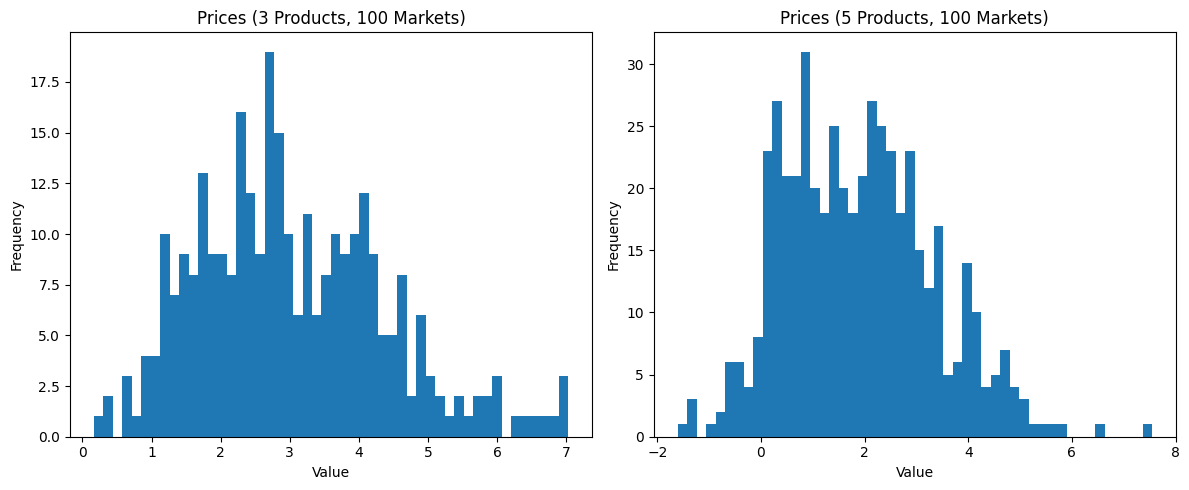

In [8]:
plot_two_histograms(df_3p['P_opt'].values, df_5p['P_opt'].values, bins=50, labels=('Prices (3 Products, 100 Markets)', 'Prices (5 Products, 100 Markets)'))

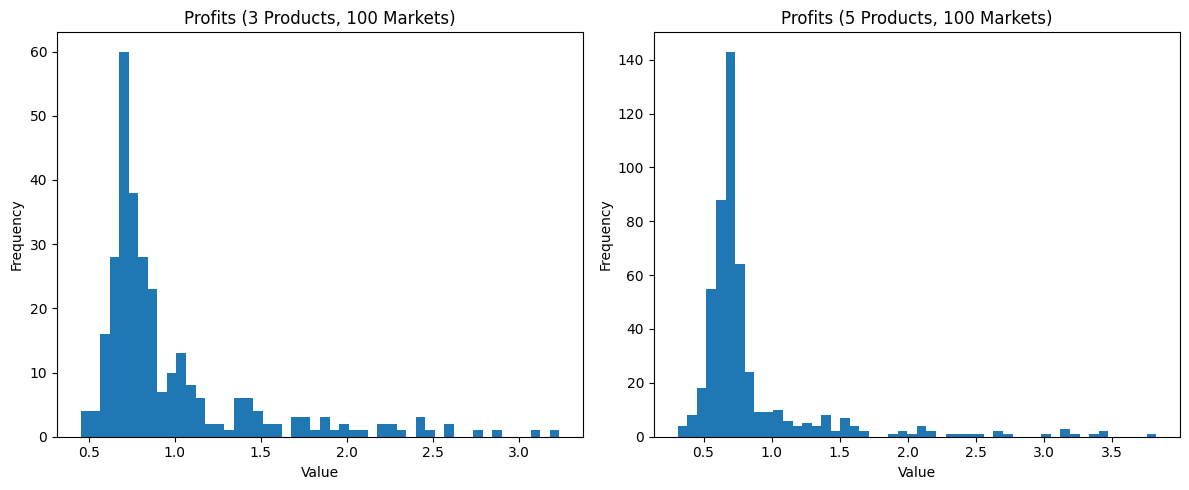

In [9]:
# NOTE: This is incomplete. Need to calculate gross profits accounting for the consumer choices. Currently, it's just per purchase profits.

plot_two_histograms(df_3p['Pi'].values, df_5p['Pi'].values, bins=50, labels=('Profits (3 Products, 100 Markets)', 'Profits (5 Products, 100 Markets)'))

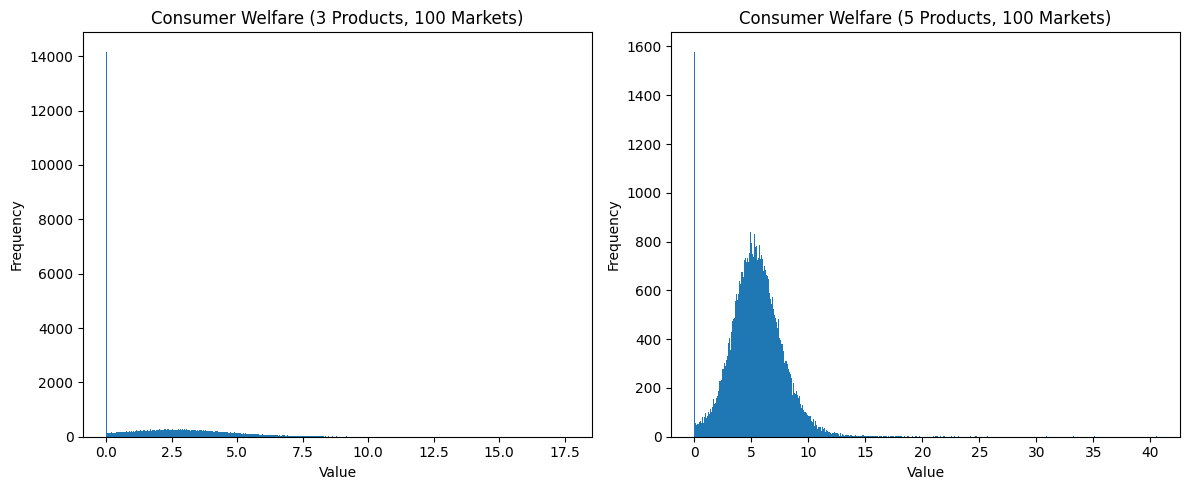

In [10]:
plot_two_histograms(consumer_welfare_3p, consumer_welfare_5p, labels=('Consumer Welfare (3 Products, 100 Markets)', 'Consumer Welfare (5 Products, 100 Markets)'))

# 2. BLP and Hausman Instruments

In [11]:
# Set the number of firms, markets, and simulated consumers in each market 
J = 3
M = 100
N = 500

In [12]:
# Set the number of BLP instruments
N_instruments = 7

### 1. (a)

NOTE: We assume the question asks us to use the $(J, M) = (3, 100)$ data set, since there is no data with 200 markets.

In [13]:
df_3p['P_other_markets'] = df_3p.groupby('product_id')['P_opt'].transform(
        lambda x: (x.sum() - x) / (len(x) - 1)
    )

In [14]:
xi = df_3p['xi_all'].values.reshape(J*M, 1)
X = df_3p[['x1', 'x2', 'x3']].values.reshape(J*M, 3)
price = df_3p['P_opt'].values.reshape(J*M, 1)
price_other_mkt = df_3p['P_other_markets'].values.reshape(J*M, 1)

In [15]:
(xi*X).mean(axis=0)

array([0.04346104, 0.02074192, 0.0355315 ])

In [16]:
(xi*price).mean()

np.float64(0.2949581371489729)

In [17]:
(xi*price_other_mkt).mean()

np.float64(0.1436795476746802)

### 1. (b)

Consider $E[\xi|X] = 0$ first. For the moment condition to be valid for all $X$ (including the firm's own product characteristics), we would need the observable product characteristics $X_{jm}$ to be independent of the unobserved product characteristics (or things like market-specific brand value), $\xi_{jm}$. In practice, this would mean that firms with certain types of observable product characteristics do not have systematically different unobserved product characteristics. This seems unlikely to hold in practice, since firms are able to both see the unobserved (to the econometrician) product characteristics before choosing the observed (again, to the econometrician) product characteristics. For example, we would expect that a "premium" car (something that is in $\xi$) typically has different product characteristics that a non-premium car. Still, to know whether this moment condition would be valid in this context, we would need more information on what type of products we are studying.

The moment condition is relevant though, as long as $X$ is included $Z_{jm}$, i.e. the product characteristics are costly. The relevance is then clear from the fact that prices are a function of marginal costs, which are a function of $X$.  

As for $E[\xi|p] = 0$, the validity depends on which prices we consider. With own prices, it's clear that validity is not satisfied, since in general, prices are higher for products with greater $\xi$, as firms choose prices with knowledge of their market-specific $\xi_{jm}$. But the mean independence might be satisfied for own prices in other markets (Hausman instruments), if we include firm fixed effects to control for the firm-level component of $\xi$ that is invariant accross markets and construct the moment condition with the market-specific part of $\xi$. Note that relevance is trivially satisfied in both these cases, since (1) prices are obviously correlated with themselves, and (2) prices in other markets are correlated with prices in a specific market because there is a common cost shifter for all markets, $W_j$. 

### 1. (c)

If the way firms choose product characteristics $X$ is such that the unobserved product characteristics are not observed before choosing observable characteristics, the BLP instruments can be used. Similarly, in the previous part we have argued that the Hausman instruments are relevant, and are also valid if there are e.g. no demand shocks that are common accross all markets or marketing campaings of the firms that include multiple markets.

### 2. (a)

To begin, we introduce some notation that is useful throughout the rest of the problem set. Let $S_{jm}$ be the observed market share of product $j$ in market $m$, and $S_m \equiv (S_{jm})_{j = 1}^J$. For each value of the parameter values $\theta$, there exists a unique mapping (as shown by Berry, 1994) between the observed market shares, $S_m$, and the vector of unobserved demand shocks $\xi_m$, defined by $s(\cdot)$:
$$
S_m = s(X_m, p_m, \xi_m; \theta),
$$
where the $X_m$ is the matrix of observed product characteristics, $p_m$ the vector of prices, and $\xi_m$ the vector of unobserved demand shocks, all in market $m$. The uniqueness of the mapping allows us to invert the market share function to arrive at:
$$
\xi_m(\theta) = s^{-1}(S_m; \theta),
$$
where we have shortened $s(\xi_m; \theta) \equiv s(X_m, p_m, \xi_m; \theta)$ for notational convenience. Finally, denote $\xi(\theta) = (\xi_m(\theta))_{m = 1}^M$.

We next write down the BLP moments. First, let $h(X, j, m)$ be a vector valued function of moments for firm $j$ in market $m$, based on all the observable product characteristics $X$ for all products and markets. The BLP instruments are the (observable) product characteristics of the firm $X_{jm}$, the sum of the characteristics of other products of the firm (in other markets) $\sum_{r \neq j, m' \neq m, r \in \mathcal{F}_j} X_{rm'}$, and the characteristics of other firms in the same market $\sum_{r \neq \mathcal{F}_j} X_{rm}$. We exclude the first element of $X_{jm}$, the constant, from all these instruments. Since there are two other product characteristics, $h(X)$ is a vector with $2 \times 3 = 6$ elements for each firm. The BLP moment is thus:
$$
E[\xi_{jm}h(X, j)] = 0.
$$

The empirical analogue of the BLP moment is:
$$
g(\xi(\theta)) = \frac{1}{M}\Sigma_{m = 1}^M \Sigma_{j = 1}^J \xi_{jm} h(X, j, m).
$$
Let $s^{-1}_j(S_m; \theta)$ denote the $j$th element of $s^{-1}_j(S_m; \theta)$. We thus have:
$$
g(\xi(\theta)) = \frac{1}{M}\Sigma_{m = 1}^M \Sigma_{j = 1}^J s^{-1}_j(S_m; \theta) h(X, j, m).
$$

### 2. (b)

The objective function in the MPEC problem is simply:
$$
Q(\theta) \equiv g(\xi(\theta))^T W g(\xi(\theta)),
$$
for some weighting matrix $W$. We can thus write the MPEC problem in its entirety as:
$$
\begin{aligned}
\min _{\theta, \xi, \eta} \eta^{\prime} W \eta & \\
\text { subject to } & g(\xi)=\eta, \\
& s(\xi ; \theta)=S.
\end{aligned}
$$

# Here's code that is compatible with the $\delta$ approach (as opposed to the $\xi$ approach).

In [18]:
X = jnp.array(df_3p[['x1', 'x2', 'x3']].values)
prices = jnp.array(df_3p[['P_opt']].values)
shares = jnp.array(df_3p[['shares']].values)

In [19]:
sigma_alpha_init = 1
eta_init =  jnp.ones((N_instruments, 1))
delta_init = jnp.ones((J*M, 1))
params_init = jnp.concatenate([np.array([sigma_alpha_init]).reshape(-1,1), eta_init, delta_init], axis=0).flatten()

# For speed, compute this outside of the function and pass it later
alphas_repeat = jnp.repeat(np.array(alphas_3p.values), repeats=J, axis=0)

# Random coefficients nu on the prices
nus_on_prices = (alphas_repeat-1) * prices.reshape(-1, 1)

In [20]:
deltas_correct = (5 + df_3p['x2'] + df_3p['x3'] - df_3p['P_opt'] + df_3p['xi_all']).values.reshape(300, -1)

In [21]:
# Prepend the new element
first_elems = jnp.ones(1+N_instruments).reshape(-1, 1)
params_correct = jnp.vstack([first_elems, deltas_correct]).reshape(-1)

# Define parameters: 

In [22]:
M=100
J=3
N_instruments=7
N=500
MJN = (M, J, N_instruments, N)

In [23]:
#### Solve initial deltas for improved initial guess. 
res = solve_init_deltas(params_init, shares, nus_on_prices, MJN)

In [24]:
W_costs = df_3p[['w']].values

In [25]:
# Get matrix of regressors
Xbar = df_3p[['x1', 'x2', 'x3', 'P_opt']].values.reshape(J*M, 4)

# Get the matrix of instruments (including x1, x2, and the BLP moments). 
Z = jnp.array(blp_instruments_all(X, W_costs, prices, MJN))[:, :N_instruments]

#Projection matrix onto the instruments
Pz = Z @ jnp.linalg.inv(Z.T @ Z) @ Z.T
#Annihiliator matrix to get xi from delta
Az = jnp.eye(Pz.shape[0]) - Xbar @ jnp.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz
#This thing gets the value of beta.
M_iv_est = (np.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz)
# GMM weighting matrix
W = np.eye(N_instruments)

In [26]:
# Define the constraints list
constraints = [
    {
        'type': 'eq',  # Equality constraint g(x) = eta
        'fun': lambda x: np.asarray(constraint_g(x, Z, Az, MJN)),  # Convert to NumPy
        'jac': lambda x: np.asarray(constraint_g_jac(x, Z, Az, MJN))  # Convert Jacobian to NumPy
    },
    {
        'type': 'eq',  # Equality constraint s(x) = shares
        'fun': lambda x: np.asarray(constraint_s(x, shares, nus_on_prices, MJN)),
        'jac': lambda x: np.asarray(constraint_s_jac(x, shares, nus_on_prices, MJN))
    }
]

In [27]:
# Silence warning about delta_grad==0.0
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

# Solve optimization
tolerance = 1e-34
W = np.eye(N_instruments)

result = minimize(
    fun=lambda x: objective_mpec(x, W, MJN),
    x0=params_init,
    constraints=constraints,
    method='trust-constr',
    jac=lambda x: objective_jac(x, W, MJN),
    hess=lambda x: objective_hess(x, W, MJN),
    options={'xtol': tolerance,
             'gtol': tolerance,
             'barrier_tol': tolerance,
             'sparse_jacobian': True,
             'disp': True,
             'verbose': 3
            }, 
)

# Output results
if result.success:
    print("Optimal solution:", result.x)
else:
    print("Optimization failed:", result.message)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |   1   |   0   | +7.0000e+00 | 1.00e+00 | 1.81e-04 | 1.00e+00 | 1.00e+00 |   0   |
|   2   |   2   |   1   | +4.5000e+00 | 5.60e+00 | 2.52e-04 | 8.02e-01 | 1.00e+00 |   1   |
|   3   |   3   |   2   | +1.8362e-01 | 3.14e+01 | 7.07e-05 | 4.13e-01 | 5.64e+01 |   1   |
|   4   |   4   |   3   | +6.6574e-02 | 1.12e+02 | 2.02e-04 | 1.06e-01 | 4.19e+02 |   1   |
|   5   |   5   |   4   | +4.3206e-02 | 1.12e+02 | 1.65e-04 | 2.49e-02 | 4.19e+02 |   1   |
|   6   |   6   |   5   | +3.2150e-02 | 1.12e+02 | 1.74e-04 | 3.81e-03 | 6.88e+02 |   1   |
|   7   |   7   |   6   | +4.7792e-02 | 1.12e+02 | 4.78e-04 | 8.67e-04 | 6.88e+02 |   1   |
|   8   |   8   |   7   | +7.2791e-02 | 1.12e+02 | 6.86e-04 | 2.59e-04 | 6.88e+02 |   1   |
|   9   |   9   |   8   | +9.1617e-02 | 1.12e+02 | 8.00e-04 | 6.65e-05 | 7.07e+0

In [28]:
result

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 0.007858522534739792
                x: [ 9.888e-01  1.575e-14 ...  4.559e+00  4.951e+00]
              nit: 661
             nfev: 1174
             njev: 579
             nhev: 579
         cg_niter: 560
     cg_stop_cond: 2
             grad: [ 0.000e+00  3.150e-14 ...  0.000e+00  0.000e+00]
  lagrangian_grad: [-6.127e-17  0.000e+00 ... -2.847e-16 -2.435e-16]
           constr: [array([ 4.385e-19,  5.394e-19,  8.086e-19, -2.776e-17,
                           6.939e-18,  5.421e-19,  3.469e-18]), array([ 6.776e-21,  0.000e+00, ...,  5.551e-17,
                           0.000e+00])]
              jac: [<Compressed Sparse Row sparse matrix of dtype 'float64'
                   	with 2092 stored elements and shape (7, 308)>, <Compressed Sparse Row sparse matrix of dtype 'float64'
                   	with 1200 stored elements and shape (300, 308)>]
      constr_n

In [29]:
# Calculate betas
thetastar = result.x #Get the estimated "true" value of theta
delta_hat = thetastar[N_instruments + 1:].reshape(300, 1)
beta_hat = M_iv_est  @ delta_hat

In [30]:
beta_hat

Array([[ 4.92818632],
       [ 0.95515674],
       [ 1.02872379],
       [-0.96756758]], dtype=float64)

### Standard Errors
The variance-covarience matrix is: 
$$
    V_{GMM} = \left[G^\intercal G\right]^{-1}G^\intercal \bar B G \left[G^\intercal G\right]^{-1}
$$
where
$$
    G \approx \frac{1}{JM} \sum_{j,t} \frac{\partial g(\theta)}{\partial \theta}, 
$$
$$
    \bar B \approx \frac{1}{JM} \sum_{j,t} g(\theta)g(\theta)^\intercal, 
$$

Here, the function $g(\theta)$ represents the vector of moment conditions (before averaging):
$$
    g(\theta) = f(z_{jm})\xi_{jm}
$$


### Calculate G.
To derive $d\delta/d\sigma,$ totally differentiate the share-matching constraint:
$$
S(\delta, \sigma) - s = 0
$$
$$
\nabla_\theta S(\delta, \sigma) = 0
$$
$$
\underbrace{D_\delta S(\delta, \sigma)}_{JM\times J_M} \underbrace{d\delta}_{JM\times 1} +  \underbrace{\frac{\partial S(\delta, \sigma)}{\partial \sigma}}_{JM\times 1} \underbrace{d\sigma}_{1\times 1} = 0
$$
$$
    \frac{d\delta}{d\sigma} = - \left[D_\delta S(\delta, \sigma)\right]^{-1} \left[\frac{\partial S(\delta, \sigma)}{\partial \sigma}\right]
$$

In total, the matrix $G$ is given by: 

$$
\frac{1}{JM} Z^\intercal A_z \begin{bmatrix}
     \frac{d\delta}{d\sigma}_{JM\times 1}& \mathbf 0_{JM\times n_I} & \mathbb I_{JM\times JM} \end{bmatrix}
$$

In [31]:
se_sigma, se_betas = standard_errors(thetastar, Z, Az, M_iv_est, shares, nus_on_prices, MJN)

In [32]:
se_sigma

np.float64(0.01634260513502858)

In [33]:
se_betas

array([0.271207  , 0.21354112, 0.06062612, 0.09132179])

### Standard errors should get lower if we use this VCV matrix to derive the optimal weigting matrix and run it again

# Consumer welfare, profits, etc.

\begin{equation}
\eta_{j k t}=\frac{\partial s_{j t} p_{k t}}{\partial p_{k t} s_{j t}}= \begin{cases}-\frac{p_{j t}}{s_{j t}} \int \alpha_i s_{i j t}\left(1-s_{i j t}\right) d P^*(v) & \text { if } j=k, \\ \frac{s_{j t t}}{s_{j t}} \int \alpha_i s_{i j t} s_{i k t} d P_v^*(v) & \text { otherwise. }\end{cases}
\end{equation}

In [34]:
beta = np.array([5.0, 1.0, 1.0])

In [35]:
#Predicted deltas, xis, and moment conditions
deltahat = thetastar[1+N_instruments:].reshape(-1, 1)
xi_hat = np.array(Az@deltahat)

betas_true = np.array([5.0, 1.0, 1.0])
alpha_true = 1.0
sigma_alpha_true = 1.0
xi_true = xi_hat

In [36]:
elasticities_true = calculate_price_elasticity(betas_true, alpha_true, sigma_alpha_true, xi_true, X, prices, shares, MJN)

In [37]:
elasticities_true.shape

(3, 3, 100)

In [38]:
elasticities_true[:, :, 1]

array([[-1.77790587e+01,  4.38540593e+00,  1.21850777e+00],
       [ 1.04040431e-03, -1.01747032e+00,  8.80165331e-01],
       [ 1.41162936e-03,  4.29797906e+00, -5.50955307e+00]])

In [39]:
elasticities_true.transpose(2, 0, 1).reshape(-1, J)

array([[-9.15879403e+00,  2.26347146e+00,  6.20353175e-01],
       [ 5.36991444e-04, -8.77269199e-01,  6.02009758e-01],
       [ 7.18673100e-04,  2.93970376e+00, -3.86781348e+00],
       [-1.77790587e+01,  4.38540593e+00,  1.21850777e+00],
       [ 1.04040431e-03, -1.01747032e+00,  8.80165331e-01],
       [ 1.41162936e-03,  4.29797906e+00, -5.50955307e+00],
       [-1.80911098e+01,  4.45838081e+00,  1.24576863e+00],
       [ 1.05771705e-03, -1.03931965e+00,  8.66301077e-01],
       [ 1.44321080e-03,  4.23027783e+00, -5.44435404e+00],
       [-1.73382644e+01,  4.27901918e+00,  1.18433542e+00],
       [ 1.01516486e-03, -1.03637819e+00,  8.95692599e-01],
       [ 1.37204103e-03,  4.37380103e+00, -5.60552058e+00],
       [-1.84738692e+01,  4.55343436e+00,  1.27112958e+00],
       [ 1.08026778e-03, -1.01342777e+00,  8.68483138e-01],
       [ 1.47259122e-03,  4.24093317e+00, -5.43993864e+00],
       [-2.03600802e+01,  5.00670827e+00,  1.41787992e+00],
       [ 1.18780358e-03, -1.07324359e+00

In [40]:
elasticities_true.mean(axis=2)

array([[-1.81362485e+01,  4.47364438e+00,  1.24273247e+00],
       [ 1.06133821e-03, -1.03779682e+00,  8.90008170e-01],
       [ 1.43969343e-03,  4.34604312e+00, -5.57392686e+00]])

Assuming the firms' conduct is Nash Bertrand pricing, we can back out the marginal costs from the firms' first-order conditions. The FOC within a given market is then:

$$
0=\frac{\partial \pi_f}{\partial p_k}=\frac{\partial}{\partial p_k} \sum_{j \in F_f} s_j\left(p_j-m c_j\right)=s_k+\sum_{j \in F_f} \frac{\partial s_j}{\partial p_k}\left(p_j-m c_j\right),
$$
where $F_f$ denotes the set of products (in the market) that are produced by firm $f$. This can then be rewritten in vector form:
$$
0=s+\Delta(p-m c)
$$

where $\Delta$ is a $J \times J$ matrix with $\Delta_{j, k}$ equal to $\left(\frac{\partial s_j}{\partial p_k}\right)$ if both $j$ and $k$ owned by the same firm, and equal to zero otherwise. The vector of marginal costs for all products is then:
$$
m c=\Delta^{-1} s+p.
$$



If the pricing is marginal cost pricing, marginal costs simply equal prices:
$$
mc_{jm} = p_{jm}.
$$
For the perfect collusion and oligopoly case, consider again the marginal cost function derived in the earlier part:
$$
m c=\Delta^{-1} s+p = (\Omega \circ \mathcal{S})^{-1} s + p.
$$
Here, as before, $\Delta$ is a $J \times J$ matrix with $\Delta_{j, k}$ equal to $\left(\frac{\partial s_j}{\partial p_k}\right)$ if both $j$ and $k$ owned by the same firm, and equal to zero otherwise. In the notation above, $\Delta$ is decomposed in to the Hadamard product $(\circ)$ between the ownership matrix $\Omega$ and the matrix of price elasticities $\mathcal{S}$.

If the conduct is perfect collusion, the firms act as one merged entity. In other words, they internalize the fact that raising prices in one product leads some consumers to choose a "competing" firms product. The profit from this diversion under collusion isn't lost, so prices have upward pressure. In this case (with three products in the market), maginal costs are given by the equation above with the ownership matrix being full of ones:
$$
\Omega_{\textit{collusion}} = \begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}.
$$
If the pricing is oligopoly pricing, the firms have markups, but they only consider the demand of their own product when setting prices. That is, the ownership matrix takes the following form:
$$
\Omega_{\textit{oligopoly}} = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}.
$$

In [41]:
mc_true = calculate_marginal_costs(elasticities_true, "oligopoly", prices, shares, MJN)

In [42]:
calculate_consumer_surplus(betas_true, alpha_true, sigma_alpha_true, xi_true, X, prices, MJN)

array([2.10114266, 2.86155902, 1.71605703, 1.2230538 , 1.54860909,
       0.41185063, 0.53160962, 0.95314834, 2.2118882 , 1.18379417,
       0.72628576, 1.38913771, 1.31340578, 1.10904918, 1.31330706,
       1.34838991, 1.74799308, 1.04803027, 1.79268048, 0.41340584,
       0.48123912, 1.46680686, 3.03262627, 1.73405157, 1.58580338,
       2.55020991, 1.99993764, 1.79119835, 0.32218176, 0.61354894,
       2.48271913, 2.09017062, 0.90432605, 2.46589525, 1.61311387,
       1.00506707, 0.66980914, 0.47722266, 1.41765322, 0.81045505,
       2.24200466, 1.16677412, 1.48730013, 0.91023998, 0.67269878,
       1.08717322, 1.44415863, 0.80116514, 2.38375643, 1.66891027,
       1.20096882, 1.812917  , 1.23271703, 1.25236461, 2.08970085,
       1.23350222, 1.20684677, 0.903741  , 1.05930196, 2.02403441,
       1.77040594, 1.72629536, 0.82209968, 1.28906423, 1.07372978,
       1.1528785 , 1.9915819 , 1.02192132, 0.15550307, 0.39651302,
       0.48532561, 1.55615342, 1.49904884, 1.73468465, 0.55505

In [43]:
# Example: Create a 300-element vector
vector = np.arange(1, 301)

# Reshape into a 300x3 matrix with block diagonal structure
blocks = []
for i in range(0, len(vector), 3):  # Iterate over the vector in steps of 3
    diag_matrix = np.diag(vector[i:i+3])  # Create a diagonal matrix from 3 elements
    blocks.append(diag_matrix)  # Append to the list of blocks

# Stack the blocks vertically
result = np.vstack(blocks)

In [44]:
p = np.ones(J*M)

In [45]:
m = 0
J = 3

In [46]:
(p[m*J:m*J + J].reshape(-1, 1) - mc_true[m*J:m*J + J])

array([[-5.34211869],
       [-0.11145007],
       [-1.34074575]])

In [47]:
alphas_3p

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.459167,5.884180,1.971698,4.097428,6.555217,2.388255,3.205104,2.693668,1.439808,3.811777,...,2.121925,3.204048,1.906425,2.652181,1.861316,2.207001,16.921627,1.825300,4.267808,2.790577
1,1.164331,3.472568,2.231101,1.467444,1.554061,1.291696,1.264168,1.617682,2.098685,2.886905,...,1.623449,4.058482,6.381258,1.605354,6.812489,1.577187,3.518375,2.583451,3.979012,3.385556
2,2.177550,3.150537,1.724178,1.338244,1.339693,1.740729,1.428346,1.927806,1.941619,1.317096,...,1.927935,1.437735,8.333255,3.009438,2.357702,1.513167,2.212286,6.031073,2.293920,2.746592
3,6.708169,1.381475,7.120157,2.877553,1.227747,3.022240,1.982550,3.435808,1.594228,1.918745,...,1.243142,1.329105,2.174126,1.316545,1.292955,1.125987,1.926625,1.582379,1.460462,1.152907
4,4.153592,1.949765,4.434796,1.862246,2.148364,1.574352,1.255009,1.687643,2.122256,2.939613,...,1.205135,4.823257,1.604649,2.897509,3.073975,2.251860,5.708858,1.158354,1.975596,2.152342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.738072,2.453627,2.217932,1.895465,1.580405,9.495191,1.441795,1.799045,1.293296,1.503219,...,2.498556,1.411992,2.888860,4.402363,1.367009,1.090293,1.619494,1.776680,3.124805,1.224563
96,1.456950,1.750375,2.564296,1.745497,1.644485,2.197861,1.466611,1.520726,1.736882,1.205386,...,1.464891,1.540580,1.510068,1.555739,1.620869,5.612213,3.222380,1.511282,1.335071,1.741637
97,3.910218,2.179362,2.158694,2.970227,1.645846,1.488458,1.619290,5.326170,2.754789,1.762164,...,2.728470,2.287183,2.758265,3.051942,2.601664,1.590773,2.565270,7.005647,2.983963,1.806173
98,4.949290,1.757981,3.554508,4.202782,3.560659,1.654924,1.255670,2.052356,2.620498,3.318173,...,1.201871,3.742776,4.477862,1.491072,1.705906,1.617479,1.629628,4.471825,1.885111,3.338661


In [88]:
def calculate_price_elasticity(betas, alpha, sigma_alpha, xi, X, prices, shares, MJN):

    M, J, N_instruments, N = MJN    

    # Draw alphas and calculate the utilities for each consumer
    alphas = (sigma_alpha*np.random.lognormal(0.0, 1.0, M*N) + alpha).reshape(M, N)
    
    utilities = (betas.reshape(1, 3) @ X.T).reshape(J*M, -1) - prices*np.repeat(alphas, repeats=J, axis=0) + xi

    # Reshape utilities for markets and products
    utilities_reshaped = utilities.reshape(M, J, N)  # Shape: (M, J, N)
    
    # Compute the stabilization constant (max utility per market per individual)
    max_utilities = jnp.max(utilities_reshaped, axis=1, keepdims=True)  # Shape: (M, 1, N)
    
    # Stabilized exponentials
    exp_utilities = jnp.exp(utilities_reshaped - max_utilities)  # Shape: (M, J, N)
    
    # Adjust the "outside option" (1 becomes exp(-max_utilities))
    outside_option = jnp.exp(-max_utilities)  # Shape: (M, 1, N)
    
    # Compute the stabilized denominator
    sum_exp_utilities = outside_option + exp_utilities.sum(axis=1, keepdims=True)  # Shape: (M, 1, N)
    
    # Compute shares
    ind_shares = exp_utilities / sum_exp_utilities  # Shape: (M, J, N)
    ind_shares = ind_shares.reshape(J*M, N)
    
    # Create a (J*M) x (J*M) matrix that will store the elasticities
    elasticities = np.zeros((J, J, M))
    
    # Calculate price elasticities
    for m in range(M):
        for j in range(J):
            for k in range(J):
                if j == k:
                    elast = (-prices[j]/shares[j])*alphas[m]*ind_shares[j, :]*(1 - ind_shares[j, :])
                else:
                    elast = (prices[k]/shares[j])*alphas[m]*ind_shares[j, :]*ind_shares[k, :]
                elasticities[j, k, m] = elast.sum()/N
                
    return elasticities

In [ ]:
elast = lambda x: calculate_price_elasticity(betas_true, alpha_true, sigma_alpha_true, xi_true, X, prices, shares, MJN)
elast_jac = lambda x: jacobian(calculate_price_el

In [85]:
def calculate_price_elasticity_jax(betas, alpha, sigma_alpha, xi, X, prices, shares, MJN):

    M, J, N_instruments, N = MJN    

    # Draw alphas and calculate the utilities for each consumer
    alphas = (sigma_alpha*np.random.lognormal(0.0, 1.0, M*N) + alpha).reshape(M, N)
    
    utilities = (betas.reshape(1, 3) @ X.T).reshape(J*M, -1) - prices*np.repeat(alphas, repeats=J, axis=0) + xi

    # Reshape utilities for markets and products
    utilities_reshaped = utilities.reshape(M, J, N)  # Shape: (M, J, N)
    
    # Compute the stabilization constant (max utility per market per individual)
    max_utilities = jnp.max(utilities_reshaped, axis=1, keepdims=True)  # Shape: (M, 1, N)
    
    # Stabilized exponentials
    exp_utilities = jnp.exp(utilities_reshaped - max_utilities)  # Shape: (M, J, N)
    
    # Adjust the "outside option" (1 becomes exp(-max_utilities))
    outside_option = jnp.exp(-max_utilities)  # Shape: (M, 1, N)
    
    # Compute the stabilized denominator
    sum_exp_utilities = outside_option + exp_utilities.sum(axis=1, keepdims=True)  # Shape: (M, 1, N)
    
    # Compute shares
    ind_shares = exp_utilities / sum_exp_utilities  # Shape: (M, J, N)
    ind_shares = ind_shares.reshape(J*M, N)
    
    # Reshape prices and shares to align with markets and products
    prices = prices.reshape(M, J, 1)  # Shape: (M, J, 1)
    shares = shares.reshape(M, J, 1)  # Shape: (M, J, 1)
    
    # Reshape alphas and individual shares
    alphas_matrix = alphas[:, None, :]  # Shape: (M, 1, N)
    ind_shares_matrix = ind_shares.reshape(M, J, N)  # Shape: (M, J, N)
    
    # Compute own-price elasticities (j == k)
    own_effect = (
        (-prices / shares) * alphas_matrix * ind_shares_matrix * (1 - ind_shares_matrix)
    )  # Shape: (M, J, N)
    
    # Compute cross-price elasticities (j != k)
    cross_effect = (
        (prices / shares)
        * alphas_matrix
        * ind_shares_matrix[:, :, None, :]  # Expand j dimension
        * ind_shares_matrix[:, None, :, :]  # Expand k dimension
    )  # Shape: (M, J, J, N)
    
    # Aggregate over consumers (N)
    own_effect_aggregated = own_effect.sum(axis=2)  # Shape: (M, J)
    cross_effect_aggregated = cross_effect.sum(axis=3)  # Shape: (M, J, J)
    
    # Combine own and cross effects
    elasticities = np.zeros((J, J, M))  # Shape: (J, J, M)
    elasticities += own_effect_aggregated.transpose(1, 0)[:, :, None] * np.eye(J)[None, :, :]  # Add own effects
    elasticities += cross_effect_aggregated.transpose(1, 2, 0)  # Add cross effects
    
    # Normalize by the number of consumers (N)
    elasticities /= N
                
    return elasticities

In [86]:
calculate_price_elasticity(betas_true, alpha_true, sigma_alpha_true, xi_true, X, prices, shares, MJN)[:, :, 0]

array([[-9.20008587e+00,  2.27226633e+00,  6.25268242e-01],
       [ 5.39077959e-04, -8.47358113e-01,  5.88261382e-01],
       [ 7.24367157e-04,  2.87256838e+00, -3.77165166e+00]])

In [87]:
calculate_price_elasticity_jax(betas_true, alpha_true, sigma_alpha_true, xi_true, X, prices, shares, MJN)[0, :, :]

ValueError: Incompatible shapes for broadcasting: shapes=[(100, 3, 500), (100, 3, 1, 500)]

In [76]:
def predict_prices_and_shares(ownership, mc, betas, alpha, sigma_alpha, xi, X, MJN):
    
    M, J, N_instruments, N = MJN

    # Draw alphas and calculate the utilities for each consumer
    alphas = (sigma_alpha*np.random.lognormal(0.0, 1.0, M*N) + alpha).reshape(M, N)

    def predict_ind_shares(p):
        utilities = (betas.reshape(1, 3) @ X.T).reshape(J*M, -1) - p.reshape(-1, 1)*np.repeat(alphas, repeats=J, axis=0) + xi

        # Reshape utilities for markets and products
        utilities_reshaped = utilities.reshape(M, J, N)  # Shape: (M, J, N)
    
        # Compute the stabilization constant (max utility per market per individual)
        max_utilities = jnp.max(utilities_reshaped, axis=1, keepdims=True)  # Shape: (M, 1, N)
    
        # Stabilized exponentials
        exp_utilities = jnp.exp(utilities_reshaped - max_utilities)  # Shape: (M, J, N)
    
        # Adjust the "outside option" (1 becomes exp(-max_utilities))
        outside_option = jnp.exp(-max_utilities)  # Shape: (M, 1, N)
    
        # Compute the stabilized denominator
        sum_exp_utilities = outside_option + exp_utilities.sum(axis=1, keepdims=True)  # Shape: (M, 1, N)

        # Compute shares
        ind_shares = exp_utilities / sum_exp_utilities  # Shape: (M, J, N)

        return ind_shares.reshape(J*M, N)
    
    def zeta(p):
        
        ind_shares = predict_ind_shares(p)
        mkt_shares = ind_shares.sum(axis=1)/N

        lambda_diag = (ind_shares*np.repeat(alphas, repeats=J, axis=0)).sum(axis=1)/N
        
        # Reshape into a (J*M, J) matrix with block diagonal structure
        blocks = []
        for i in range(0, len(lambda_diag), J):  # Iterate over the vector in steps of 3
            diag_matrix = np.diag(lambda_diag[i:i+J])  # Create a diagonal matrix from 3 elements
            diag_matrix_inv = np.linalg.inv(diag_matrix)
            blocks.append(diag_matrix_inv)  # Append to the list of blocks
        
        # Stack the blocks vertically
        lambda_mat_inv = np.vstack(blocks)
        
        gamma_mat = np.zeros((M, J, J))
        for m in range(M):
            for j in range(J):
                for k in range(J):
                    gamma_mat[m, j, k] = (ind_shares[J*m + j, :]*ind_shares[J*m + k, :]*alphas[m, :]).sum()/N

        gamma_mat = gamma_mat.reshape(J*M, J)
        
        zeta = np.zeros(J*M)
        for m in range(M):
            zeta[m*J:m*J + J] = (lambda_mat_inv[m*J:m*J + J, :] @ (ownership*gamma_mat[m*J:m*J + J, :]).T @ (p[m*J:m*J + J].reshape(-1, 1) - mc[m*J:m*J + J]) 
                                - lambda_mat_inv[m*J:m*J + J, :] @ mkt_shares[m*J:m*J + J].reshape(-1, 1)).reshape(-1)

        return zeta

    def contraction_mapping(zeta, p0, tol=1e-8, max_iter=1000):
        """
        Implements the contraction mapping: p <- c + zeta(p).
    
        Parameters:
        - zeta: function zeta(p), mapping p to a vector or scalar of the same shape as p.
        - p0: initial guess for p (scalar or array).
        - tol: convergence tolerance (default 1e-8).
        - max_iter: maximum number of iterations (default 1000).
    
        Returns:
        - p: converged value of p.
        """
        p = p0
        for n_iter in range(max_iter):
            p_new = mc.reshape(-1) + zeta(p)  # Apply the contraction mapping
            if np.linalg.norm(p_new - p) < tol:  # Check for convergence
                print("Contraction mapping converged, found prices that satisfy the FOC.")
                print("Iterations:", n_iter)
                return p_new
            p = p_new
        raise RuntimeError("Contraction mapping did not converge within the maximum number of iterations.")

    p_init = np.ones(J*M)
    
    res_prices = contraction_mapping(zeta, p_init)
    res_shares = predict_ind_shares(res_prices).sum(axis=1)/N
    
    return res_prices, res_shares

In [77]:
ownership_true = np.array(
    [
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ]
)

In [78]:
ownership_merger = np.array(
    [
        [1.0, 1.0, 0.0],
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ]
)

In [79]:
merger_p, merger_s = predict_prices_and_shares(ownership_merger, mc_true, betas_true, alpha_true, sigma_alpha_true, xi_true, X, MJN)

RuntimeError: Contraction mapping did not converge within the maximum number of iterations.

In [75]:
true_p, true_s = predict_prices_and_shares(ownership_true, mc_true, betas_true, alpha_true, sigma_alpha_true, xi_true, X, MJN)

RuntimeError: Contraction mapping did not converge within the maximum number of iterations.

In [59]:
merger_p[3:6]

array([2.45843883, 1.04619236, 1.03785624])

In [53]:
prices[3:6]

Array([[2.46404997],
       [1.16859547],
       [1.15416239]], dtype=float64)

In [54]:
merger_s[3:6]

array([2.45847155, 1.04621975, 1.03788207])

In [55]:
shares[:3]

Array([[5.18797590e-05],
       [7.18442824e-01],
       [1.19751055e-01]], dtype=float64)

In [56]:
res_s[:3]

NameError: name 'res_s' is not defined